---
title: Part 1. GRASS GIS 101
description: Learn the basics of GRASS GIS, a powerful open-source geospatial procesing engine.
format:
    html:
        code-fold: false
author: 
    - Corey T. White
    - Vaclav Petras
date: '2024-09-10'
keep-ipynb: true
toc: true
toc-depth: 4
image:  images/webinar_title.webp
categories: [geospatial, GRASS v8.5, jupyter, lidar, STAC]
page-layout: full
title-block-banner: true
---

# GRASS GIS 101

This notebook is a quick introduction to GRASS and Jupyter Notebooks.

By default all cells are running Python:

In [1]:
import sys
v = sys.version_info
print(f"We are using Python {v.major}.{v.minor}.{v.micro}")

We are using Python 3.10.12


## Colab Setup

If you are running this notebook in Colab, you will need to install GRASS GIS and its Python API. You can do this by running the following cell:

In [ ]:
%%bash

apt-get install grass grass-dev grass-doc
# leave the directory with source code
cd ~

# download sample data
mkdir -p grassdata
mkdir -p output
curl -SL https://grass.osgeo.org/sampledata/north_carolina/nc_basic_spm_grass7.zip > nc_basic_spm_grass7.zip
unzip -qq nc_basic_spm_grass7.zip
mv nc_basic_spm_grass7 grassdata
rm nc_basic_spm_grass7.zip

pip install figlet

In [2]:
import os
os.chdir(os.path.expanduser("~"))

But you can also run shell commands by prefixing them with `!` or use `%%bash` to run the whole cell as a shell script.

In [3]:
# !sudo apt-get install figlet

!figlet "GRASS GIS 101"

  ____ ____      _    ____ ____     ____ ___ ____    _  ___  _ 
 / ___|  _ \    / \  / ___/ ___|   / ___|_ _/ ___|  / |/ _ \/ |
| |  _| |_) |  / _ \ \___ \___ \  | |  _ | |\___ \  | | | | | |
| |_| |  _ <  / ___ \ ___) |__) | | |_| || | ___) | | | |_| | |
 \____|_| \_\/_/   \_\____/____/   \____|___|____/  |_|\___/|_|
                                                               


In [4]:
%%bash
grass -v

GRASS GIS 8.3.1
Geographic Resources Analysis Support System (GRASS) is Copyright,
1999-2023 by the GRASS Development Team, and licensed under terms of the
GNU General Public License (GPL) version >=2.

This GRASS GIS 8.3.1 release is coordinated and produced by
the GRASS Development Team with contributions from all over the world.

This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
General Public License for more details.


## GRASS Project Setup

In [4]:
# import standard Python packages
import os
import subprocess
import json
from io import StringIO
from pathlib import Path
from IPython.display import IFrame
from pandas import DataFrame

## Setup GRASS environment

In [5]:
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)


In [6]:
# import GRASS GIS python packages
%reload_ext autoreload
%autoreload 2
import grass.script as gs
import grass.jupyter as gj

In [7]:
# create a temporary folder where to place our GRASS project
import tempfile
tempdir = tempfile.TemporaryDirectory()

## Create a new GRASS project

In [8]:
gs.create_project(path=tempdir.name, name="foss4g2024", epsg="2817", overwrite=True)

In [9]:
# start GRASS in the recently created project
session = gj.init(Path(tempdir.name,"foss4g2024"))

In [ ]:
# !ogrinfo "/vsizip//vsicurl/https://www.stlouis-mo.gov/data/upload/data-files/stl_boundary.zip" -al
# !ogrinfo /vsizip//vsicurl/https://www.stlouis-mo.gov/data/upload/data-files/streets.zip -al
# !ogrinfo /vsizip/vsicurl/https://static.stlouis-mo.gov/open-data/planning/neighborhoods/neighborhoods.zip/Neighborhoods -al
!ogrinfo "https://services1.arcgis.com/fBc8EJBxQRMcHlei/arcgis/rest/services/NPS_Land_Resources_Division_Boundary_and_Tract_Data_Service/FeatureServer/2/query?outFields=*&where=1%3D1&f=geojson" -al

### Import Vector data

Let's import some vector data from the city of St. Louis' open data portal.

[https://www.stlouis-mo.gov/data/datasets/index.cfm](https://www.stlouis-mo.gov/data/datasets/index.cfm)


#### City Boundary

In [10]:
gs.run_command("v.import",
   input="/vsizip//vsicurl/https://www.stlouis-mo.gov/data/upload/data-files/stl_boundary.zip",
   output="stl_boundary",
   layer="stl_boundary",
   snap=0.0001
)

#### Streets

In [11]:
streets_url="/vsizip//vsicurl/https://www.stlouis-mo.gov/data/upload/data-files/streets.zip"
# streets_url="http://maps.stlouisco.com/arcgis/rest/services/OpenData/OpenData/FeatureServer/1/query?outFields=*&where=1%3D1&f=geojson"
gs.run_command("v.import",
   input=streets_url,
   output="stl_streets",
   snap=0.0001,
   layer="tgr_str_cl"
)

#### St. Louis Arch Park Boundary

In [15]:
neigh_url="https://services1.arcgis.com/fBc8EJBxQRMcHlei/arcgis/rest/services/NPS_Land_Resources_Division_Boundary_and_Tract_Data_Service/FeatureServer/2/query?outFields=*&where=1%3D1&f=geojson"
gs.run_command("v.import",
   input=neigh_url,
   output="stl_park",
   snap=0.001,
   layer="OGRGeoJSON",
   extent="region"
)

In [ ]:
gs.run_command("v.info", map="stl_park")

### Visualize data

#### Folium Web Map

In [21]:
map = gj.InteractiveMap(map_backend="folium")

# help(map.add_vector)        
map.add_vector("stl_boundary")
# map.add_vector("stl_park")
map.add_layer_control()
map.show()

#### Map Figure

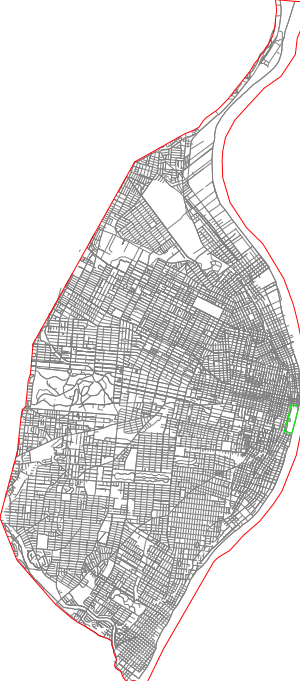

In [41]:
map = gj.Map(width=300)
map.d_vect(map="stl_streets", color="grey", fill_color="none")
map.d_vect(map="stl_park", color="green", fill_color="none")
map.d_vect(map="stl_boundary", color="red", fill_color="none")
map.show()

### Import Raster Data

In [43]:
gs.run_command("g.region", vector="stl_boundary", res=30, flags="ap")

projection: 99 (NAD83(HARN) / Missouri West)
zone:       0
datum:      nad83harn
ellipsoid:  grs80
north:      298260
south:      271020
west:       1214160
east:       1226670
nsres:      30
ewres:      30
rows:       908
cols:       417
cells:      378636


#### Export STAC Catalog

In [45]:
gs.run_command("g.extension", extension="t.stac", url="https://github.com/cwhite911/grass-addons", branch="t.stac-lazy-load")

https://stacindex.org/catalogs

In [47]:
gs.run_command("t.stac.catalog",
               url="https://earth-search.aws.element84.com/v1/",
               format="plain",
               flags="b")

---------------------------------------------------------------------------
Catalog: Earth Search by Element 84
---------------------------------------------------------------------------
Client Id: earth-search-aws
Client Description: A STAC API of public datasets on AWS
Client STAC Extensions: []
Client catalog_type: ABSOLUTE_PUBLISHED
---------------------------------------------------------------------------
Collections: 9
---------------------------------------------------------------------------
Collection Id | Collection Title
---------------------------------------------------------------------------
sentinel-2-pre-c1-l2a: Sentinel-2 Pre-Collection 1 Level-2A 
cop-dem-glo-30: Copernicus DEM GLO-30
naip: NAIP: National Agriculture Imagery Program
cop-dem-glo-90: Copernicus DEM GLO-90
landsat-c2-l2: Landsat Collection 2 Level-2
sentinel-2-l2a: Sentinel-2 Level-2A
sentinel-2-l1c: Sentinel-2 Level-1C
sentinel-2-c1-l2a: Sentinel-2 Collection 1 Level-2A
sentinel-1-grd: Sentinel-1 Lev

In [48]:
gs.run_command("t.stac.collection",
               url="https://earth-search.aws.element84.com/v1/",
               collection="cop-dem-glo-30",
               format="plain",
               flags="b"
            )

Collection ID: cop-dem-glo-30
STAC Version: 1.0.0
Description: The Copernicus DEM is a Digital Surface Model (DSM) which represents the surface of the Earth including buildings, infrastructure and vegetation. GLO-30 Public provides limited worldwide coverage at 30 meters because a small subset of tiles covering specific countries are not yet released to the public by the Copernicus Programme.
Extent: {'spatial': {'bbox': [[-180, -90, 180, 90]]}, 'temporal': {'interval': [['2021-04-22T00:00:00Z', '2021-04-22T00:00:00Z']]}}
License: proprietary
Keywords: ['Copernicus', 'DEM', 'DSM', 'Elevation']
---------------------------------------------------------------------------

Summary:
gsd: [30]
platform: ['tandem-x']
proj:epsg: [4326]
storage:platform: ['AWS']
storage:region: ['eu-central-1']
storage:requester_pays: [False]
---------------------------------------------------------------------------

Item Assets Keys: ['data']
-------------------------------------------------------------------

### Import Evelvation Data

The `t.stac.item` module will download the Copernicus DEM GLO-30 data from the STAC catalog.

In [49]:
gs.run_command("t.stac.item",
               url="https://earth-search.aws.element84.com/v1/",
               collection="cop-dem-glo-30",
               format="plain",
               extent="region",
               method="bicubic",
               resolution="value",
               memory="5000",
               resolution_value=30,
               flags="d"
            )

Import Url: /vsis3/copernicus-dem-30m/Copernicus_DSM_COG_10_N38_00_W091_00_DEM/Copernicus_DSM_COG_10_N38_00_W091_00_DEM.tif
Importing: cop-dem-glo-30.Copernicus_DSM_COG_10_N38_00_W091_00_DEM.data


Let's rename our elevation raster to `cop-dem-glo-30`.

In [50]:
gs.run_command("g.rename", raster="cop-dem-glo-30.Copernicus_DSM_COG_10_N38_00_W091_00_DEM.data,cop-dem-glo-30")

In [52]:
map = gj.InteractiveMap(width=500, height=500, map_backend="ipyleaflet", use_region=True)
map.add_raster("cop-dem-glo-30")
map.add_vector("stl_boundary", fill_color="none", line_color="red")
map.add_vector("stl_park", fill_color="none", line_color="green")
map.add_layer_control()
map.show()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

projection: 99 (NAD83(HARN) / Missouri West)
zone:       0
datum:      nad83harn
ellipsoid:  grs80
north:      298260
south:      271020
west:       1214160
east:       1226670
nsres:      30
ewres:      30
rows:       908
cols:       417
cells:      378636


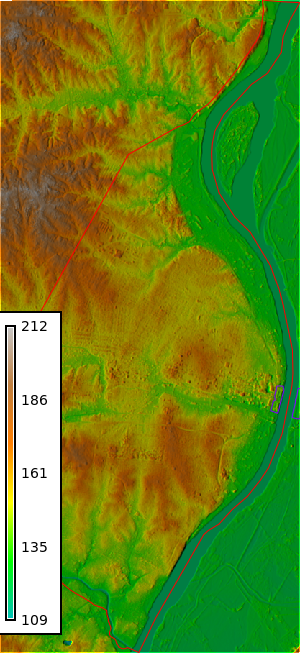

In [58]:
#| fig-cap: A map of the evelvation in the St. Louis area
#| layout: [1]

gs.run_command("g.region", raster="cop-dem-glo-30", res=30, flags="ap")
gs.run_command("r.colors", map="cop-dem-glo-30", color="elevation")
gs.run_command("r.relief", input="cop-dem-glo-30", output="relief", overwrite=True)

map = gj.Map(width=300)
map.d_shade(shade="relief", color="cop-dem-glo-30")
map.d_vect(map="stl_boundary", color="red", fill_color="none")
map.d_vect(map="stl_park", color="purple", fill_color="none")
# map.d_vect(map="stl_streets", color="grey", fill_color="none", width=0.25)
map.d_legend(raster="cop-dem-glo-30", at="5,50,2,5", flags="b")
map.show()

Let's calculate the slope of the elevation raster.

In [60]:
gs.run_command("r.slope.aspect", elevation="cop-dem-glo-30", slope="slope", aspect="aspect", overwrite=True)
gs.run_command("r.colors", map="slope", color="sepia", flags="e")

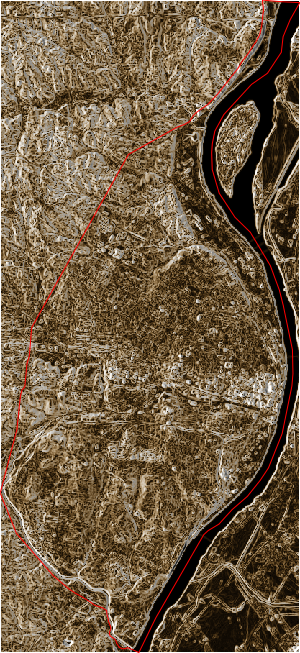

In [61]:
#| fig-cap: A map of the slope in the St. Louis area
#| layout: [1]

map = gj.Map(width=300)
map.d_shade(shade="relief", color="slope", brighten=30)
map.d_vect(map="stl_boundary", color="red", fill_color="none")
map.show()

### Distance to the nearest street

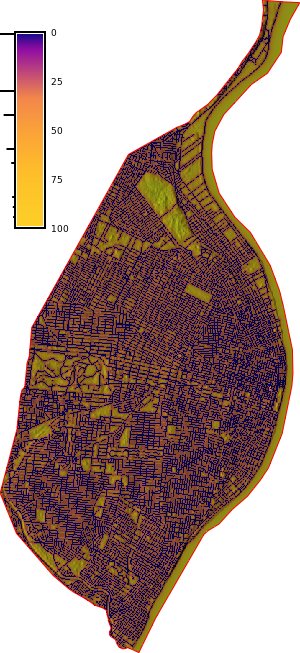

In [62]:
#| layout: [1,1]
gs.run_command("r.mask", vector="stl_boundary")
gs.run_command("v.to.rast", input="stl_streets", output="stl_streets", use="value", type="line", overwrite=True)
gs.run_command("r.grow.distance", input="stl_streets", distance="dist_to_road")
gs.run_command("r.colors", map="dist_to_road", color="plasma", flags="e")
map1 = gj.Map(width=300)
map1.d_shade(shade="relief", color="dist_to_road")
map1.d_vect(map="stl_boundary", color="red", fill_color="none")
map1.d_legend(raster="dist_to_road", at="95,65,5,15", range="0,100", flags="ds")
map1.show()


#### Road Density

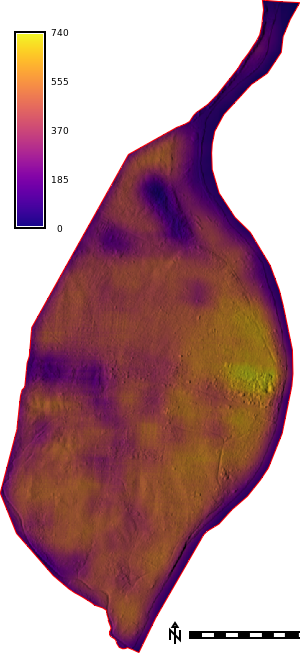

In [63]:
gs.run_command("r.neighbors", flags="", input="stl_streets", output="road_dens", size=37, method="count", memory=30000, nprocs=24)
gs.run_command("r.colors", map="road_dens", color="plasma", flags="")
map2 = gj.Map(width=300)
map2.d_shade(shade="relief", color="road_dens")
map2.d_vect(map="stl_boundary", color="red", fill_color="none")
map2.d_legend(raster="road_dens", at="95,65,5,15", flags="s")
map2.d_barscale(at="55,5,5,5", flags="n")
map2.show()

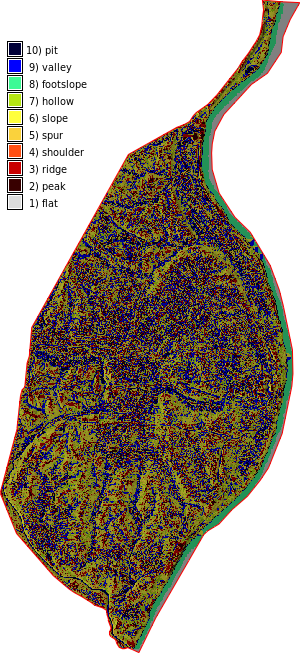

In [64]:
gs.run_command("r.geomorphon", elevation="cop-dem-glo-30", search=15, flat=0.1, forms="geomorphon", overwrite=True)
map = gj.Map(width=300)
map.d_shade(shade="relief", color="geomorphon")
map.d_vect(map="stl_boundary", color="red", fill_color="none")
map.d_legend(raster="geomorphon", at="95,65,2,5", flags="")
map.show()

Let's run some bash commands to calculate flow accumulation.

We can start by downloading the new `r.flowaccumulation` module from the [GRASS Addons repository](https://github.com/OSGeo/grass-addons/).

In [66]:
%%bash

g.extension extension=r.flowaccumulation

# calculate positive flow accumulation and drainage directions using r.watershed
# for comparison, use -s (SFD)
r.watershed -sa elevation=cop-dem-glo-30 accumulation=flow_accum drainage=drain_directions

# calculate flow accumulation using r.flowaccumulation
r.flowaccumulation input=drain_directions output=flow_accum_new

# copy color table
r.colors map=flow_accum_new raster=flow_accum

Fetching <r.flowaccumulation> from <https://github.com/OSGeo/grass-addons/>
(be patient)...
Already on 'grass8'


Your branch is up to date with 'origin/grass8'.


Compiling...
Installing...
Updating extensions metadata file...
Updating extension modules metadata file...
Installation of <r.flowaccumulation> successfully finished
SECTION 1a (of 4): Initiating Memory.
SECTION 1b (of 4): Determining Offmap Flow.
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
SECTION 2: A* Search.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 3: Accumulating Surface Flow with SFD.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
SECTION 4: Closing Maps.
Writing out only positive flow accumulation values.
Cells with a likely underestimate for flow accumulation can no longer be
identified.
Using

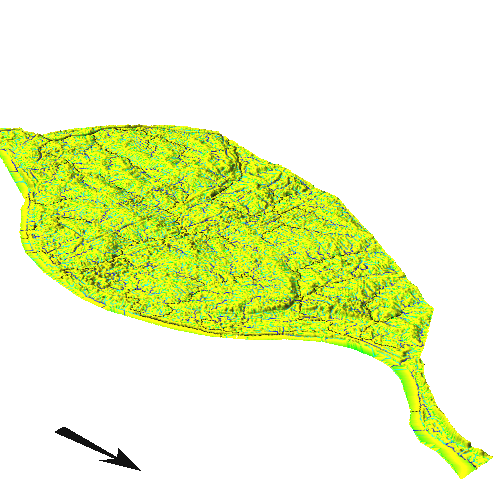

In [76]:
map3d = gj.Map3D(width=500, height=500)
map3d.render(
    elevation_map="cop-dem-glo-30",
    color_map="flow_accum_new",
    zexag=4, 
    perspective=12, 
    height=10000, 
    resolution_fine=1,
    arrow_position=[100,50],
)
map3d.show()

In [88]:
gs.run_command("r.mask", flags="r")

Let's zoom in on the Arch Park area.

In [79]:
gs.run_command("g.region", vector="stl_park", flags="ap")  

projection: 99 (NAD83(HARN) / Missouri West)
zone:       0
datum:      nad83harn
ellipsoid:  grs80
north:      282180
south:      280770
west:       1225440
east:       1226970
nsres:      30
ewres:      30
rows:       47
cols:       51
cells:      2397


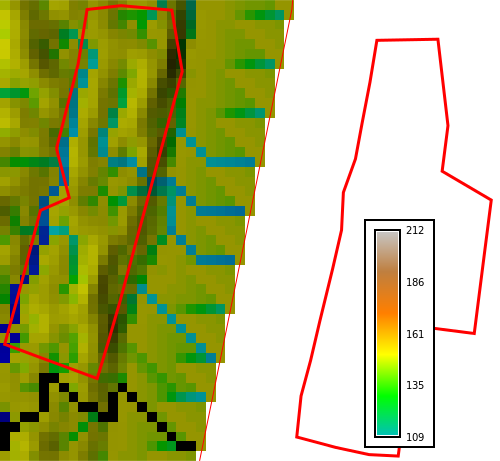

In [97]:
gs.run_command("r.mask", vector="stl_boundary")
map = gj.Map(width=500, use_region=True)
map.d_shade(shade="relief", color="flow_accum_new")
map.d_vect(map="stl_boundary", color="red", fill_color="none")
map.d_vect(map="stl_park", color="red", fill_color="none", width=3)
map.d_legend(raster="cop-dem-glo-30", at="5,50,80,75", flags="b")
map.show()

projection: 99 (NAD83(HARN) / Missouri West)
zone:       0
datum:      nad83harn
ellipsoid:  grs80
north:      298260
south:      271020
west:       1214160
east:       1226670
nsres:      30
ewres:      30
rows:       908
cols:       417
cells:      378636



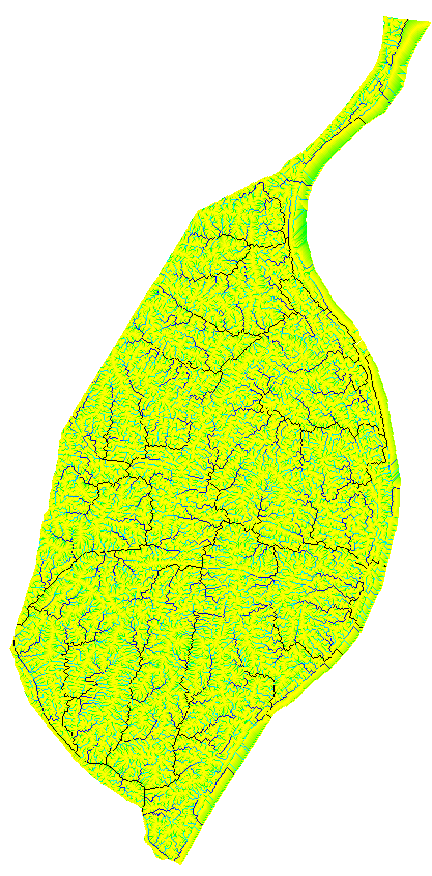
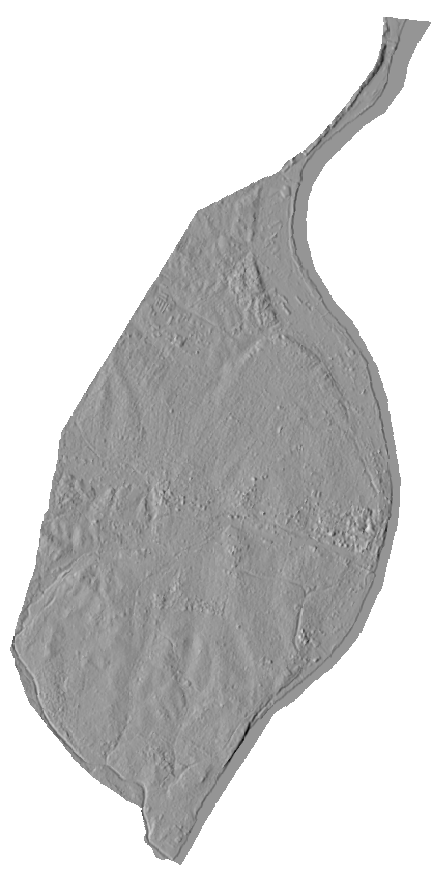

In [101]:
gs.run_command("r.mask", vector="stl_boundary")
gs.run_command("g.region", raster="flow_accum_new", res=30, flags="ap")
map = gj.InteractiveMap(width=500, map_backend="folium", use_region=True)
map.add_raster("flow_accum_new", opacity=0.5)
map.add_raster("relief", opacity=0.75)
map.add_vector("stl_boundary", fill_color="none", line_color="red")
map.add_vector("stl_park", fill_color="none", line_color="green")
map.show()

## Let's practice!

1. Set the computational region to the `cop-dem-glo-30` raster map.

# Add your python code here

Let's move to [Part 2: Actinia 101](intro_actinia.ipynb)